## Imports

In [1]:
import itertools
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import numpy as np
import pandas as pd
import re
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gianc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gianc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import time
import datetime

## Data

In [4]:
%%time
data = "dataset/Cell_Phones_and_Accessories_5.json.gz"
df = pd.read_json(data, lines = True, compression = "gzip")
df.head()

Wall time: 28.5 s


,asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
0,7508492919,NaN,5,Looks even better in person. Be careful to not...,"08 4, 2014",A24E3SXTC62LJI,Claudia Valdivia,{'Color:': ' Bling'},Can't stop won't stop looking at it,1407110400,True,NaN
1,7508492919,NaN,5,When you don't want to spend a whole lot of ca...,"02 12, 2014",A269FLZCB4GIPV,sarah ponce,NaN,1,1392163200,True,NaN
2,7508492919,NaN,3,"so the case came on time, i love the design. I...","02 8, 2014",AB6CHQWHZW4TV,Kai,NaN,Its okay,1391817600,True,NaN
3,7508492919,NaN,2,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,"02 4, 2014",A1M117A53LEI8,Sharon Williams,NaN,CASE,1391472000,True,NaN
4,7508492919,NaN,4,"I liked it because it was cute, but the studs ...","02 3, 2014",A272DUT8M88ZS8,Bella Rodriguez,NaN,Cute!,1391385600,True,NaN


In [5]:
df.shape

(1128437, 12)

Remove rows with missing values from `reviewText`:

In [6]:
df = df[df.reviewText.notnull()]

In [7]:
df.shape

(1127672, 12)

See proportion of positive ($>3$) and critical ($\leq 3$) reviews:

In [8]:
df["positive"] = df.overall > 3

In [9]:
df.groupby("positive").size()

positive
False    236886
True     890786
dtype: int64

In [10]:
df.groupby("positive").size()/(df.shape[0])

positive
False    0.210066
True     0.789934
dtype: float64

The class to predict is highly unbalanced. We can sample in order to have a balanced class:

In [11]:
sample_size = 200000 # needs to be less than the number of observations in the minority class
sample_df = df.groupby('positive').apply(lambda x: x.sample(sample_size))

In [12]:
sample_df = sample_df.reset_index(level=0, drop=True) # remove outer level of multiindex

In [13]:
sample_df.groupby("positive").size()

positive
False    200000
True     200000
dtype: int64

#### Choice: Unbalanced or Balanced Classes

Definition of unbalanced `X` and `y` (class to predict). The classification with this choice should be better at predicting sentiment on the reviews from the Amazon dataset.

In [14]:
X = df.reviewText.values
y = df.overall.values > 3

Definition of balanced `X` and `y` (class to predict). The classification with this choice should be better at predicting sentiment on tweets (which might not be unbalanced in the same way as this dataset).

In [ ]:
# X = sample_df.reviewText.values
# y = sample_df.overall.values > 3

## Preprocessing/Normalization

#### Slang Dictionary

In [16]:
import json

In [17]:
# from bs4 import BeautifulSoup
# import requests

# From https://stackoverflow.com/questions/8502387/python-module-to-remove-internet-jargon-slang-acronym
# Slightly modified

# resp = requests.get("http://www.netlingo.com/acronyms.php")
# soup = BeautifulSoup(resp.text, "html.parser")
# slang_repl= {}
# key=""
# value=""
# for div in soup.findAll('div', attrs={'class':'list_box3'}):
#     for li in div.findAll('li'):
#         for a in li.findAll('a'):
#             key = a.text
#         value = li.text.split(key)[1].split("-or-")[0] # only keep a single alternative
#         slang_repl[key.lower()]=value.lower()
# 
# with open('slang.json', 'w') as fid:
#     json.dump(slangdict, fid)

In [18]:
with open('slang.json', 'r') as fid:
    slang_repl = json.load(fid)

In [19]:
from nltk.corpus import stopwords
stopws = stopwords.words("english")

In [20]:
# avoid clashes with stop words
for k in stopws:
    if k in slang_repl:
        del slang_repl[k]

In [21]:
for k in list(slang_repl.keys())[120:125]:
    print(k, ":", slang_repl[k])

afaics : as far as i can see
afaict : as far as i can tell
afaik : as far as i know
afair : as far as i remember
afaiu : as far as i understand


#### Emoticons Dictionary

In [108]:
emoticon_repl = {
    # positive emoticons
    r":-?d+": " good ", # :D, :-D, :DD, ecc. in lower case
    r":-?\)+": " good ", # :-), :), :-)), :)), ecc
    r";-?\)+": " good ", # ;). ;)). ;-), ecc.
    r"\(+-?:": " good ", # (:, (-:, ecc.
    r"gr8t*": " great ",
    # negative emoticons
    r"[\s\r\t\n]+:/+": " bad ", # :/
    r":\\+": " bad ", # :\
    r"[\s\r\t\n]+\)-?:": "bad",  # ):, )):, )-:, ecc.
    r":-?\(+": " bad ", # :(, :-(, :((, ecc.
    #"d+-?:" : "bad" # D:, D-:, ecc. in lower case
    r"[\s\t\r\n]+d+-?:": "bad"
    # ":-?S+": " bad " # :S, :-S, :SS
}
# TODO: add other emoticons?

We have used the following function to check if an emoticon is present in some review:

In [27]:
# Check if re is present in some review
def check_presence(regex, stop = 1):
    j = 0
    # tv = False
    for i in range(len(X)):
        if re.search(regex, X[i].lower()):
            # tv = True
            j += 1
            print("Review #",i)
            sentiment = "positive" if y[i] else "negative"
            print("Sentiment: {}".format(sentiment))
            print("Occurrences of the regex {} :".format(regex), re.findall(regex, X[i].lower()))
            print("Review text:", X[i]+"\n")
            if j == stop:
                break
    # return tv

In [31]:
check_presence(r":-?d+")

Review # 3248
Sentiment: positive
Occurrences of the regex :-?d+ : [':d']
Review text: Great!!! Love to use this to change my voice to a squeaker :D



In [32]:
check_presence(r"[\s\t\r\n]+d+-?:")

Review # 18255
Sentiment: negative
Occurrences of the regex [\s\t\r\n]+d+-?: : [' d:']
Review text: This kit fit my car just fine but IT DOESN'T FIT THE STEREO! It says it's double din but it's not big enough for a double din unit to fit in it. It took me a long time to get around to installing it and now I can't return it. Complete waste of money D:<



In [33]:
check_presence(r"[\s\r\t\n]+\)-?:")

Review # 94758
Sentiment: negative
Occurrences of the regex [\s\r\t\n]+\)-?: : [' ):']
Review text: This product was fantastic when I first got it. I could easily transfer my music from my Macbook Pro to my Samsung Galaxy Tab 2.
My SD card became corrupted (not related to the product) so I had to go put everything back on my tablet and this adapter no longer works. ): It seems like it's too loose for the input.



In [34]:
check_presence(r"[\s\r\t\n]+:/+")

Review # 2167
Sentiment: negative
Occurrences of the regex [\s\r\t\n]+:/+ : [' :/']
Review text: I guess I would have rated this if I would have received the right product. Instead of getting the Nexus 7 Case, BoxWave sent me a case that looked like above, but was fitted for a Samsung Galaxy SIII Cell Phone. Clearly, someone just looked at the picture on the invoice and guessed at what product was ordered. Won't be ordering from this vendor again. I'm still waiting for my refund... And I'm still without a case. :/



Function for checking if an emoticon corresponds to the expected sentiment:

In [115]:
from scipy.stats import norm
from scipy.stats import chi2_contingency

In [118]:
def check_sentiment(regex):
    # https://online.stat.psu.edu/stat414/node/268/
    pos = 0
    neg = 0
    lx = len(X)
    
    for i in range(lx):
        if re.search(regex, X[i].lower()):
            if y[i]:
                pos += 1
            else:
                neg += 1
                
    tot_reviews = len(y)
    tot_pos = np.sum(y)
    tot_neg = tot_reviews - tot_pos
                
    n1 = pos + neg
    n2 = tot_reviews - n1
    
    if emoticon_repl[regex] in [" good ", " great "]:
        test1 = pos
        test2 = tot_pos - pos
        sent = "positive"        
    else:
        test1 = neg
        test2 = tot_neg - neg
        sent = "negative"

        
    # One tailed proportion test    
    p1 = test1/n1
    p2 = test2/n2
    p = (test1 + test2)/(n1+n2)
    num = (p1-p2)
    denom = np.sqrt(p*(1-p)*(1/n1 + 1/n2))
    prop_zstat = num/denom
    prop_pvalue = norm.sf(abs(prop_zstat))
    
    
    # Chisq test
    obs = np.array([[pos, neg],
                    [(tot_pos-pos), (tot_neg-neg)]])
    chi_zstat, chi_pvalue, _, _ = chi2_contingency(obs)
    
    cont_table = "\n{0:>16s} | No {0}\nPos {1:12d} | {2:d}\nNeg {3:12d} | {4:d}\n"\
    .format(regex, pos,tot_pos-pos, neg, tot_neg-neg)
    
    #"Positive reviews containing regex {} : {}; p1 = {:.2f}\n".format(regex, pos, pos/n1) + \
    #"Positive reviews not containing regex {} : {}; p2 = {:.2f}\n".format(regex, tot_pos-pos, (tot_pos-pos)/n2) + \
    print("Contingency table:\n" + \
          cont_table + \
          "\np1: #({} reviews) / #(reviews containing {}) = {:.2f}\n".format(sent, regex, test1/n1) + \
          "p2: #({} reviews) / #(reviews not containing {}) = {:.2f}\n".format(sent, regex, test2/n2) + \
          "H_0 proportion test: p1 - p2 <= 0\n" + \
          "Proportion test p-value = {}\n".format(prop_pvalue) + \
          
          "Chisq test p-value = {}".format(chi_pvalue))

For instance, we would expect that the proportion of positive reviews containing ":)" and similar is larger than the proportion of positive reviews that do not contain ":)".

Similarly, we would expect that the proportion of negative reviews containing ":(" and similar is larger than the proportion of negative reviews that do not contain ":(".

In order to check this, we test the significance of this difference for each emoticon in the dictionary:

In [119]:
for k in emoticon_repl:
    print(k)
    # check_sentiment_chisq(k)
    check_sentiment(k)
    print("\n")

:-?d+
Contingency table:

           :-?d+ | No :-?d+
Pos          556 | 890230
Neg           26 | 236860

p1: #(positive reviews) / #(reviews containing :-?d+) = 0.96
p2: #(positive reviews) / #(reviews not containing :-?d+) = 0.79
H_0 proportion test: p1 - p2 <= 0
Proportion test p-value = 5.76840436144916e-23
Chisq test p-value = 1.9067113146196236e-22


:-?\)+
Contingency table:

          :-?\)+ | No :-?\)+
Pos         8712 | 882074
Neg          581 | 236305

p1: #(positive reviews) / #(reviews containing :-?\)+) = 0.94
p2: #(positive reviews) / #(reviews not containing :-?\)+) = 0.79
H_0 proportion test: p1 - p2 <= 0
Proportion test p-value = 1.306431934931655e-269
Chisq test p-value = 4.091879886093022e-269


;-?\)+
Contingency table:

          ;-?\)+ | No ;-?\)+
Pos         1077 | 889709
Neg          126 | 236760

p1: #(positive reviews) / #(reviews containing ;-?\)+) = 0.90
p2: #(positive reviews) / #(reviews not containing ;-?\)+) = 0.79
H_0 proportion test: p1 - p2 <= 0
Pro

There are more negative reviews containing "):" and similar than positive ones, even though the difference is not that big. For the moment we will perform the replacement

In [112]:
check_sentiment(r"[\s\r\t\n]+\)-?:")

Contingency table:

[\s\r\t\n]+\)-?: | No [\s\r\t\n]+\)-?:
Pos            8 | 890778
Neg           13 | 236873

p1: #(negative reviews) / #(reviews containing [\s\r\t\n]+\)-?:) = 0.62
p1: #(negative reviews) / #(reviews not containing [\s\r\t\n]+\)-?:) = 0.21
H_0 proportion test: p1 - p2 <= 0
Proportion test p-value = 2.1032753153533324e-06
Chisq test p-value = 1.4705261732223621e-05



Remove comment if we want to delete it from the list of emoticons to replace:

In [31]:
#del emoticon_repl["[\s\r\t\n]+\)-?:]

The "D:" emoticon is more present in the positive class, even though the difference is not that big.

In [114]:
#check_sentiment("d+-?:")
check_sentiment(r"[\s\t\r\n]+d+-?:")

Contingency table:

[\s\t\r\n]+d+-?: | No [\s\t\r\n]+d+-?:
Pos            7 | 890779
Neg            4 | 236882

p1: #(negative reviews) / #(reviews containing [\s\t\r\n]+d+-?:) = 0.36
p1: #(negative reviews) / #(reviews not containing [\s\t\r\n]+d+-?:) = 0.21
H_0 proportion test: p1 - p2 <= 0
Proportion test p-value = 0.10558609928990187
Chisq test p-value = 0.3787168023915991



In [121]:
del emoticon_repl[r"[\s\t\r\n]+d+-?:"]

#### Contracted forms

We will be interested in combinations of "not" + other terms and similar.

In [120]:
contracted_repl = {
    # casi particolari
    r"won\'t" : "will not", r"won\'" : "will not",
    r"can\'t": "can not", r"shan\'t": "shall not",
    r"shan\'": "shall not", r"ain\'t": "is not",
    r"ain\'": "is not",
    # casi generali
    r"n\'t": " not", r"\'t": " not",
    r"n\'": " not",
    r"\'s": " is",
    r"\'ve": " have", 
    r"\'re": " are", 
    r"\'ll": " will", # Might also be "shall", in any case both will be considered stop words
    r"\'d": " would", # Might also be "had", in any case both will be considered stop words
}

### Complete preprocessing function

Complete preprocessing function, including:

- lowering the text;
- deleting non-alphanumeric characters;
- substituting emoticons;
- replacing contracted forms.

In [122]:
def preprocess(sent, translate_slang = False):
    
    sent = sent.lower()
    
    for k in emoticon_repl:
        sent = re.sub(k, emoticon_repl[k], sent)

    if translate_slang:
        for k in slang_repl:
            sent = re.sub(r"\b"+re.escape(k)+r"\b", slang_repl[k], sent)
            # sent = sent.replace(k, slang_repl[k])
        
    for k in contracted_repl:
        sent = re.sub(k, contracted_repl[k], sent)
    
    # remove non-alphanumeric characters
    sent = re.sub('[^A-Za-z0-9-_ ]+', '', sent)
    # The space is needed, otherwise spaces are deleted (alternatively use [^A-Za-z0-9-_\s]+)
    # Also exclude the "-", as it might have a meaning in compound words. 
    # "_" might also be used in a meaningful way. I'll let the tokenizer decide...
    
    # Or use (a combination of) the following. (Need to better check the symbols and when the escape is needed)
    # [.,;:;!?\'\`\%\+\<\>]+
    # [.,;:;!?%"\'\`\(\)]+'
    
    # remove words containing numbers. Not sure if necessary/makes sense:
    # sent = re.sub("\S*\d+\S*\s", '', sent) 
    
    return sent

Example:

In [123]:
# X[1697]
X[27]

"crystals fell off as nothing :( that's why I really didn't like it but as soon as I saw it I liked it but the stones"

In [124]:
preprocess(X[27])

'crystals fell off as nothing  bad  that is why i really did not like it but as soon as i saw it i liked it but the stones'

In [125]:
preprocess("tbh", translate_slang = True)

'to be honest'

In [126]:
preprocess("tbh", translate_slang = False)

'tbh'

In [127]:
%%time
# Including slang translation takes too much time, tqdm estimated around 25-30 hours
# Options:
# - reduce size of slang_repl dictionary;
# - don't translate slang
X_preprocessed = [preprocess(el) for el in X]

Wall time: 2min 7s


Spell check and correction is carried out after tokenization.

### Definition of the list of Stop-words

In [43]:
from nltk.corpus import stopwords
stopws = stopwords.words("english")

The list of stop words needs to be preprocessed in the same way as the reviews:

In [44]:
prep_stopws = [preprocess(el) for el in stopws]

Words containing "not" are important for our tasks

In [45]:
np.array(prep_stopws[-36:])

array(['ain', 'aren', 'are not', 'couldn', 'could not', 'didn', 'did not',
       'doesn', 'does not', 'hadn', 'had not', 'hasn', 'has not', 'haven',
       'have not', 'isn', 'is not', 'ma', 'mightn', 'might not', 'mustn',
       'must not', 'needn', 'need not', 'shan', 'shall not', 'shouldn',
       'should not', 'wasn', 'was not', 'weren', 'were not', 'won',
       'will not', 'wouldn', 'would not'], dtype='<U10')

In [46]:
prep_stopws = prep_stopws[:-36]

Other words to remove from the stop words:

In [47]:
for word in ["not", "very", "don", "do not"]:
    prep_stopws.remove(word)

In [48]:
prep_stopws.extend(["youse", "would"]) # needed for consistency with spell checker

## Order of operations from now on:

(Execution times might be different from the following, I ran the notebook again afterwards)

#### NLTK

- Tokenization, 3min 15s
- Spell check and correction, 14min 11s
- Stop words removal, 1min 6s
- Stemming, 7min 10s (Porter) 5min 56s (Lancaster)
- Vectorization, 58.8 s (Porter), 56.6 s(Lancaster)

#### PyStemmer

Class that performs

- Tokenization
- Spell check and correction (parameter `preprocessor`)
- Stop words removal (parameter `stop_words`)
- Stemming (with `pystemmer`)
- Vectorization

8min 49s

## Tokenization/Spell Correction/StopWordsRemoval/Stemming

### NLTK

In [49]:
from nltk.tokenize import word_tokenize
def tokenize_reviews(reviews):
    tokenized_reviews = [word_tokenize(review) for review in reviews]
    return tokenized_reviews

In [50]:
%%time
X_tokenized = tokenize_reviews(X_preprocessed)

Wall time: 3min 50s


Spelling correction:

In [51]:
from spellchecker import SpellChecker
def fix_spelling_mistakes(reviews, dist=1):
    spell = SpellChecker(distance=dist)
    reviews_with_right_spell = []
    for review in reviews:
        corrected_review = [spell.correction(word) for word in review]
        reviews_with_right_spell.append(corrected_review)
    return reviews_with_right_spell

In [52]:
%%time
X_spellchecked = fix_spelling_mistakes(X_tokenized)

Wall time: 23min 24s


Stop words removal:

In [53]:
%%time
X_noStopWords = []
for review in X_spellchecked:
        cleaned_review = [word for word in review if word not in prep_stopws]
        X_noStopWords.append(cleaned_review)

Wall time: 1min 1s


In [54]:
from nltk.stem import PorterStemmer, LancasterStemmer

In [55]:
def stem_reviews(reviews, stemmer_name="Porter"):
    if stemmer_name == "Porter":
        stemmer = PorterStemmer()
    elif stemmer_name == "Lancaster":
        stemmer = LancasterStemmer()
    else:
        raise SystemError
    stemmed_reviews = []
    for review in reviews:
        stemmed_reviews.append([stemmer.stem(word) for word in review])
    return stemmed_reviews

In [56]:
%%time
X_Porter = stem_reviews(X_noStopWords, stemmer_name = "Porter")

Wall time: 8min


In [57]:
%%time
X_Lancaster = stem_reviews(X_noStopWords, stemmer_name = "Lancaster")

Wall time: 6min 43s


### PyStemmer (needs Visual C++ installed)

Definition of the class StemmedTdidfVectorized.

- `sklearn`'s `TfidfVectorizer` takes care of tokenization, stop-word removal, vectorization
- `pystemmer` takes care of stemming.

In [ ]:
import Stemmer
english_stemmer = Stemmer.Stemmer('en')

In [ ]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

## Train-test split

In [58]:
from sklearn.model_selection import train_test_split

#### NLTK

Here we are train/test splitting the set of reviews that is already tokenized and stemmed, to be passed to TfidfVectorizer for representation.

In [59]:
X_train_Porter, X_test_Porter, y_train, y_test = train_test_split(X_Porter, y,
                                                                  test_size=0.33, random_state=42)
X_train_Lancaster, X_test_Lancaster, y_train, y_test = train_test_split(X_Lancaster, y,
                                                                        test_size=0.33, random_state=42)

#### Pystemmer

Here we are train/test splitting the preprocessed set of reviews to be passed to `StemmedTfidfVectorizer` for tokenization+stemming+representation.

In [ ]:
X_train_pystemmer, X_test_pystemmer, y_train, y_test = train_test_split(X_preprocessed, y,
                                                                  test_size=0.33, random_state=42)

## Text Representation

#### NLTK

In [60]:
def rebuild_reviews(reviews):
    rebuilt_reviews = []
    for review in reviews:
        rebuilt_reviews.append(" ".join(review))
    return rebuilt_reviews

In [61]:
X_train_Porter = rebuild_reviews(X_train_Porter)
X_test_Porter = rebuild_reviews(X_test_Porter)
X_train_Lancaster = rebuild_reviews(X_train_Lancaster)
X_test_Lancaster = rebuild_reviews(X_test_Lancaster)

In [62]:
%%time
tfidf_vect_Porter = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Porter = tfidf_vect_Porter.fit_transform(X_train_Porter)
X_test_tfidf_Porter = tfidf_vect_Porter.transform(X_test_Porter)

Wall time: 1min 1s


In [63]:
%%time
tfidf_vect_Lancaster = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Lancaster = tfidf_vect_Lancaster.fit_transform(X_train_Lancaster)
X_test_tfidf_Lancaster = tfidf_vect_Lancaster.transform(X_test_Lancaster)

Wall time: 1min


#### Pystemmer

In [ ]:
%%time
spell = SpellChecker(distance=1)
tfidf_vect_pystemmer = StemmedTfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2),
                                              preprocessor = spell.correction,
                                              stop_words = prep_stopws)
X_train_tfidf_pystemmer = tfidf_vect_pystemmer.fit_transform(X_train_pystemmer)
X_test_tfidf_pystemmer = tfidf_vect_pystemmer.transform(X_test_pystemmer)

# Classification

## NB Classifier

In [64]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score

Accessory functions:

In [65]:
def print_top_features(vectorizer, clf, n = 10):
    fnames = vectorizer.get_feature_names()
    top_pos = np.argsort(clf.coef_[0])[-n:]
    top_pos = top_pos[::-1]
    print("Most discriminative features:\n",
          ", ".join(fnames[j] for j in top_pos))

In [66]:
def score_NB(clf, X_train, X_test, y_train, y_test):
    train_score = clf.score(X_train, y_train) # Train Accuracy
    test_score = clf.score(X_test, y_test)    # Test Accuracy
    
    predictions = clf.predict(X_test)
    
    prec = precision_score(y_test, predictions) # Precision
    rec = recall_score(y_test, predictions) # Recall
    f1 = f1_score(y_test, predictions) # F1
    f2 = fbeta_score(y_test, predictions, 2) # F2
    cm = confusion_matrix(y_test, predictions)
    
    proba = clf.predict_proba(X_test)

    precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])
    
    auc_score = auc(recall, precision)
    
    scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                      "Test Recall", "F1", "F2", "P/R AUC"]
    
    scores = [train_score, test_score, prec, rec, f1, f2, auc_score]
    
    print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))
    
    print(classification_report(y_test,predictions))
    
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
    plt.legend(loc="lower left")
    plt.show()

### NLTK

#### Porter

In [67]:
clf = MultinomialNB()
clf.fit(X_train_tfidf_Porter, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [68]:
print_top_features(tfidf_vect_Porter, clf, 50)

Most discriminative features:
 great, good, case, phone, love, work, not, veri, product, nice, excel, fit, like, perfect, use, well, protect, charg, screen, one, work great, look, price, easi, protector, qualiti, thank, great product, time, realli, get, veri good, recommend, need, perfectli, charger, screen protector, buy, awesom, batteri, bought, color, feel, cabl, expect, best, littl, cover, ok, fast


Train Accuracy       0.88750
Test Accuracy        0.88193
Test Precision       0.89418
Test Recall          0.96467
F1                   0.92809
F2                   0.94970
P/R AUC              0.97673
             precision    recall  f1-score   support

      False       0.81      0.57      0.67     78224
       True       0.89      0.96      0.93    293908

avg / total       0.88      0.88      0.87    372132



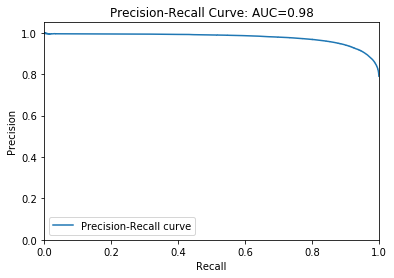

In [69]:
score_NB(clf, X_train_tfidf_Porter, X_test_tfidf_Porter, y_train, y_test)

#### Lancaster

In [70]:
clf = MultinomialNB()
clf.fit(X_train_tfidf_Lancaster, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [71]:
print_top_features(tfidf_vect_Lancaster, clf, 50)

Most discriminative features:
 gre, good, cas, phon, lov, work, not, excel, very, produc, protect, perfect, nic, charg, fit, lik, us, wel, on, screen, work gre, look, easy, pric, qual, thank, gre produc, real, tim, get, very good, recommend, screen protect, nee, buy, awesom, battery, bought, fast, col, feel, cabl, expect, cov, hold, best, littl, ok, ev, purchas


Train Accuracy       0.88586
Test Accuracy        0.88008
Test Precision       0.89178
Test Recall          0.96530
F1                   0.92709
F2                   0.94964
P/R AUC              0.97633
             precision    recall  f1-score   support

      False       0.81      0.56      0.66     78224
       True       0.89      0.97      0.93    293908

avg / total       0.87      0.88      0.87    372132



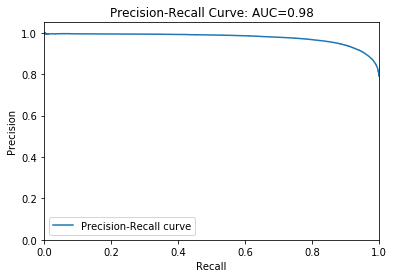

In [72]:
score_NB(clf, X_train_tfidf_Lancaster, X_test_tfidf_Lancaster, y_train, y_test)

###  PyStemmer

In [ ]:
clf = MultinomialNB()
clf.fit(X_train_tfidf_pystemmer, y_train)

In [ ]:
print_top_features(tfidf_vect_pystemmer, clf, 50)

In [ ]:
score_NB(clf, X_train_tfidf_pystemmer, X_test_tfidf_pystemmer, y_train, y_test)

In [ ]:
beep(freq = 880)

## Random forest

In [73]:
from sklearn.ensemble import RandomForestClassifier

### Porter

In [74]:
clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, verbose=2)
clf.fit(X_train_tfidf_Porter, y_train) # it takes around 30 minutes

building tree 1 of 50
building tree 2 of 50building tree 3 of 50

building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 40.3min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 57.2min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

In [75]:
train_score = clf.score(X_train_tfidf_Porter, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_Porter, y_test)    # Test Accuracy

predictions = clf.predict(X_test_tfidf_Porter)

print(classification_report(y_test,predictions))

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   16.1s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.6s


             precision    recall  f1-score   support

      False       0.85      0.56      0.68     78224
       True       0.89      0.97      0.93    293908

avg / total       0.89      0.89      0.88    372132



[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    8.0s finished


Results are more encouraging! The problem is that it's way slower than Multinomial NB.

## TruncatedSVD
The X_train vector has around 20k features: for speeding up the training phase it may be good to use dimensionality reduction methods. Their goal is to preserve "expressive power" while reducing dataset dimensionality.
Because the TFIDF matrix is a sparse one, one of the best method for performing dimensionality reduction is "TruncatedSVD"

In [76]:
%%time
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=500, random_state=42)
X_train_tfidf_Porter_svd = tsvd.fit_transform(X_train_tfidf_Porter)
X_test_tfidf_Porter_svd = tsvd.transform(X_test_tfidf_Porter)

Wall time: 4min 35s


In [77]:
print("train with old features: ",np.array(X_train_tfidf_Porter).shape)
print("train with new features:" ,np.array(X_train_tfidf_Porter_svd).shape)

train with old features:  ()
train with new features: (755540, 500)


#### Store SVD-transformed dataset

In [78]:
dump(X_train_tfidf_Porter_svd, 'X_train_tfidf_Porter_svd.joblib')
dump(X_test_tfidf_Porter_svd, 'X_test_tfidf_Porter_svd.joblib')

['X_test_tfidf_Porter_svd.joblib']

### Random Forest

In [79]:
clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, verbose=2)
clf.fit(X_train_tfidf_Porter_svd, y_train)

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.5min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.0min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

In [80]:
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test,predictions))

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.6s


             precision    recall  f1-score   support

      False       0.83      0.42      0.56     78224
       True       0.86      0.98      0.92    293908

avg / total       0.86      0.86      0.84    372132



[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished


## SVM
### LinearSVC

In [81]:
from sklearn import svm

In [86]:
clf = svm.LinearSVC(random_state=42)

In [87]:
%%time
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 6min 27s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [88]:
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       0.79      0.57      0.67     78224
       True       0.89      0.96      0.93    293908

avg / total       0.87      0.88      0.87    372132



## SVC

In [89]:
clf = svm.SVC(random_state=42, max_iter=500)

In [92]:
%%time
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 7min 29s


c:\python\python36\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=500, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [93]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       0.28      0.59      0.38     78224
       True       0.85      0.59      0.70    293908

avg / total       0.73      0.59      0.63    372132

Wall time: 3min 18s


## Adaboost
### 10 estimators

In [94]:
from sklearn.ensemble import AdaBoostClassifier

In [97]:
%%time
clf = AdaBoostClassifier(n_estimators=10, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 10min


In [98]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       0.61      0.37      0.46     78224
       True       0.85      0.94      0.89    293908

avg / total       0.80      0.82      0.80    372132

Wall time: 2.2 s


### 15 estimators

In [99]:
%%time
clf = AdaBoostClassifier(n_estimators=15, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 14min 57s


In [100]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       0.63      0.35      0.45     78224
       True       0.85      0.94      0.89    293908

avg / total       0.80      0.82      0.80    372132

Wall time: 2.97 s


Increasing the number of estimators did not lead to an improvement in performances: let's see what happens when we reduce them.
## 5 estimators

In [101]:
%%time
clf = AdaBoostClassifier(n_estimators=5, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 5min 1s


In [102]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       0.59      0.26      0.36     78224
       True       0.83      0.95      0.89    293908

avg / total       0.78      0.81      0.78    372132

Wall time: 1.45 s


Performances are a bit worse

# TODO

- Add *short* examples after some steps.
- Decide what to do with slang. Probably very necessary for preprocessing tweets. If we want to use it for the Amazon dataset, we might reduce the size of the dict by checking which terms are actually present in the reviews, and only keep the ones that are present in many reviews.
- Tweets part